# Векторные представления изображений
Как мы убедились, информация, содержащаяся в промежуточных слоях хорошо обученных нейронных сетей, достаточна для классификации изображений. Это значит, что мы можем заменить изображение этой информацией и работать с ней. Например, с предпоследнего слоя получается некоторый вектор, значит можем исходное изображение представить (описать) этим вектором.

Получили векторное представление изображения. Эти вектора не банальны, их достаточно, чтобы классифицировать изображения, значит в них установлены какие-то важные взаимосвязи между пикселями изображения.

А давайте такие вектора кластеризуем. Не окажется ли так, что они группируются в "похожие" группы. Для кластеризации и уменьшения размерности можно воспользоваться методами главных компонент PCA и T-SNE, давайте с их помощью отобразим вектора изображений в двумерное пространство.

![img](https://drive.google.com/uc?id=19U3gdTfOYzZBbTiqdmEwU0PEOmfHn-rh)

Возьмем уже обученную сеть (здесь ResNet50).

Пропустим через нее изображение. И возвратим вектор, который получается перед классификатором (здесь выход с полносвязного слоя после слоя flatten, стрелка на рис.). Будем дальше работать с этими векторами.

Все эти операции уже реализованы в библиотеке [img2vec-keras](https://github.com/jaredwinick/img2vec-keras), установим ее.

Для сравнения векторов лучше подходит "косинусное расстояние" - косинус угла между ними, чем больше, тем похожей.  




Установим библиотеку и, если потребуется, после установки нажмите "Restart Runtime".

In [1]:
!pip install git+https://github.com/jaredwinick/img2vec-keras.git

  Cloning https://github.com/jaredwinick/img2vec-keras.git to /tmp/pip-req-build-8h_nn2z0
  Running command git clone --filter=blob:none --quiet https://github.com/jaredwinick/img2vec-keras.git /tmp/pip-req-build-8h_nn2z0
  Resolved https://github.com/jaredwinick/img2vec-keras.git to commit 80c56b2e1b698e36c26c4015e8b21216fb4cafbb
  Preparing metadata (setup.py) ... done
  Created wheel for img2vec-keras: filename=img2vec_keras-0.2-py3-none-any.whl size=6194 sha256=d16c433d3488bc41a7c3ea3bcb41f61d0c63e65af50f4360918e8f3b77293f63
  Stored in directory: /tmp/pip-ephem-wheel-cache-w115d16v/wheels/da/92/ca/893e107e4c49bfd1bb057215620bc672357f0f5ca23855bf56
Successfully built img2vec-keras


In [1]:
import gdown # модуль для загрузки с гугл-диска
url = 'https://drive.google.com/uc?id=1Madin3qXe3Xexox5qOhASGulFR2wvsFz' # адрес
output = '101_ObjectCategories.tar.gz' # название загружаемого файла
gdown.download(url, output, quiet=False) # загружаем
!echo "Downloading 101_Object_Categories for image notebooks"
# распаковываем
!tar -xzf 101_ObjectCategories.tar.gz
# удаляем после распаковки
!rm 101_ObjectCategories.tar.gz
!ls
root = '101_ObjectCategories' # директория с файлами

Downloading...
From (original): https://drive.google.com/uc?id=1Madin3qXe3Xexox5qOhASGulFR2wvsFz
From (redirected): https://drive.google.com/uc?id=1Madin3qXe3Xexox5qOhASGulFR2wvsFz&confirm=t&uuid=ca43a33a-5ceb-4592-b27d-08fc9dcf7d73
To: /content/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:04<00:00, 26.4MB/s]

101_ObjectCategories  sample_data


In [2]:
from img2vec_keras import Img2Vec # подключаем библиотеку для векторных представлений

from IPython.display import Image

import glob # для работы с файлами

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity # похожесть по косинусному расстоянию.
from sklearn.decomposition import PCA # метод клавных компонент
from sklearn.manifold import TSNE # метод TSNE
from sklearn.preprocessing import StandardScaler # масштабирование, убирает среднее, единичный разброс.

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import cv2

In [3]:
img2vec = Img2Vec() # инициализируем вектора, загрузится предобученная сеть.

102967424/102967424 [==============================] - 1s 0us/step


In [4]:
image_paths = []
image_classes = ['pizza', 'schooner', 'scissors', 'panda', 'brain'] # выберем классы для отображения, проверьте с другими

# считываем пути к изображениям этих классов
for image_class in image_classes:
  image_paths.extend(glob.glob('101_ObjectCategories/' + image_class + '/*.jpg')) # только .jpg

In [5]:
# сколько их
len(image_paths)

291

In [6]:
# создаем вектора для этих изображений
image_vectors = {}
for image_path in image_paths: # для каждого файла
  vector = img2vec.get_vec(image_path) # получаем векторное представление
  image_vectors[image_path] = vector # добавляем в словарь, название=ключ.

1/1 [==============================] - 0s 20ms/step


In [7]:
# массив только с векторами, размер вектора 2048
X = np.stack(list(image_vectors.values()))

In [8]:
pca_50 = PCA(n_components=50) #  первые 50 главных компонент
pca_result_50 = pca_50.fit_transform(X) # и проецируем на них
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
print(np.shape(pca_result_50))

# 2 компоненты  TSNE
tsne = TSNE(n_components=2, verbose=1, n_iter=3000)
tsne_result = tsne.fit_transform(pca_result_50) # проецируем

Cumulative explained variation for 50 principal components: 0.7661529779434204
(291, 50)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 291 samples in 0.001s...
[t-SNE] Computed neighbors for 291 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 291 / 291
[t-SNE] Mean sigma: 12.834367
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.094376
[t-SNE] KL divergence after 2800 iterations: 0.341700


In [9]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result) # масштабируем

Читаем изображения. Порядок такой же как при создании векторов, ведь как вы помните, TSNE работает только с теми векторами на которых и обучался, с другими не может.

In [10]:
# читаем изображения
images = []
for image_path in image_paths:
  image = cv2.imread(image_path, 3) # загружаем изображение
  b,g,r = cv2.split(image)           # разделяем каналы b, g, r
  image = cv2.merge([r,g,b])         # собираем в r, g, b
  image = cv2.resize(image, (50,50)) # масштаб
  images.append(image)        # добавляем в список



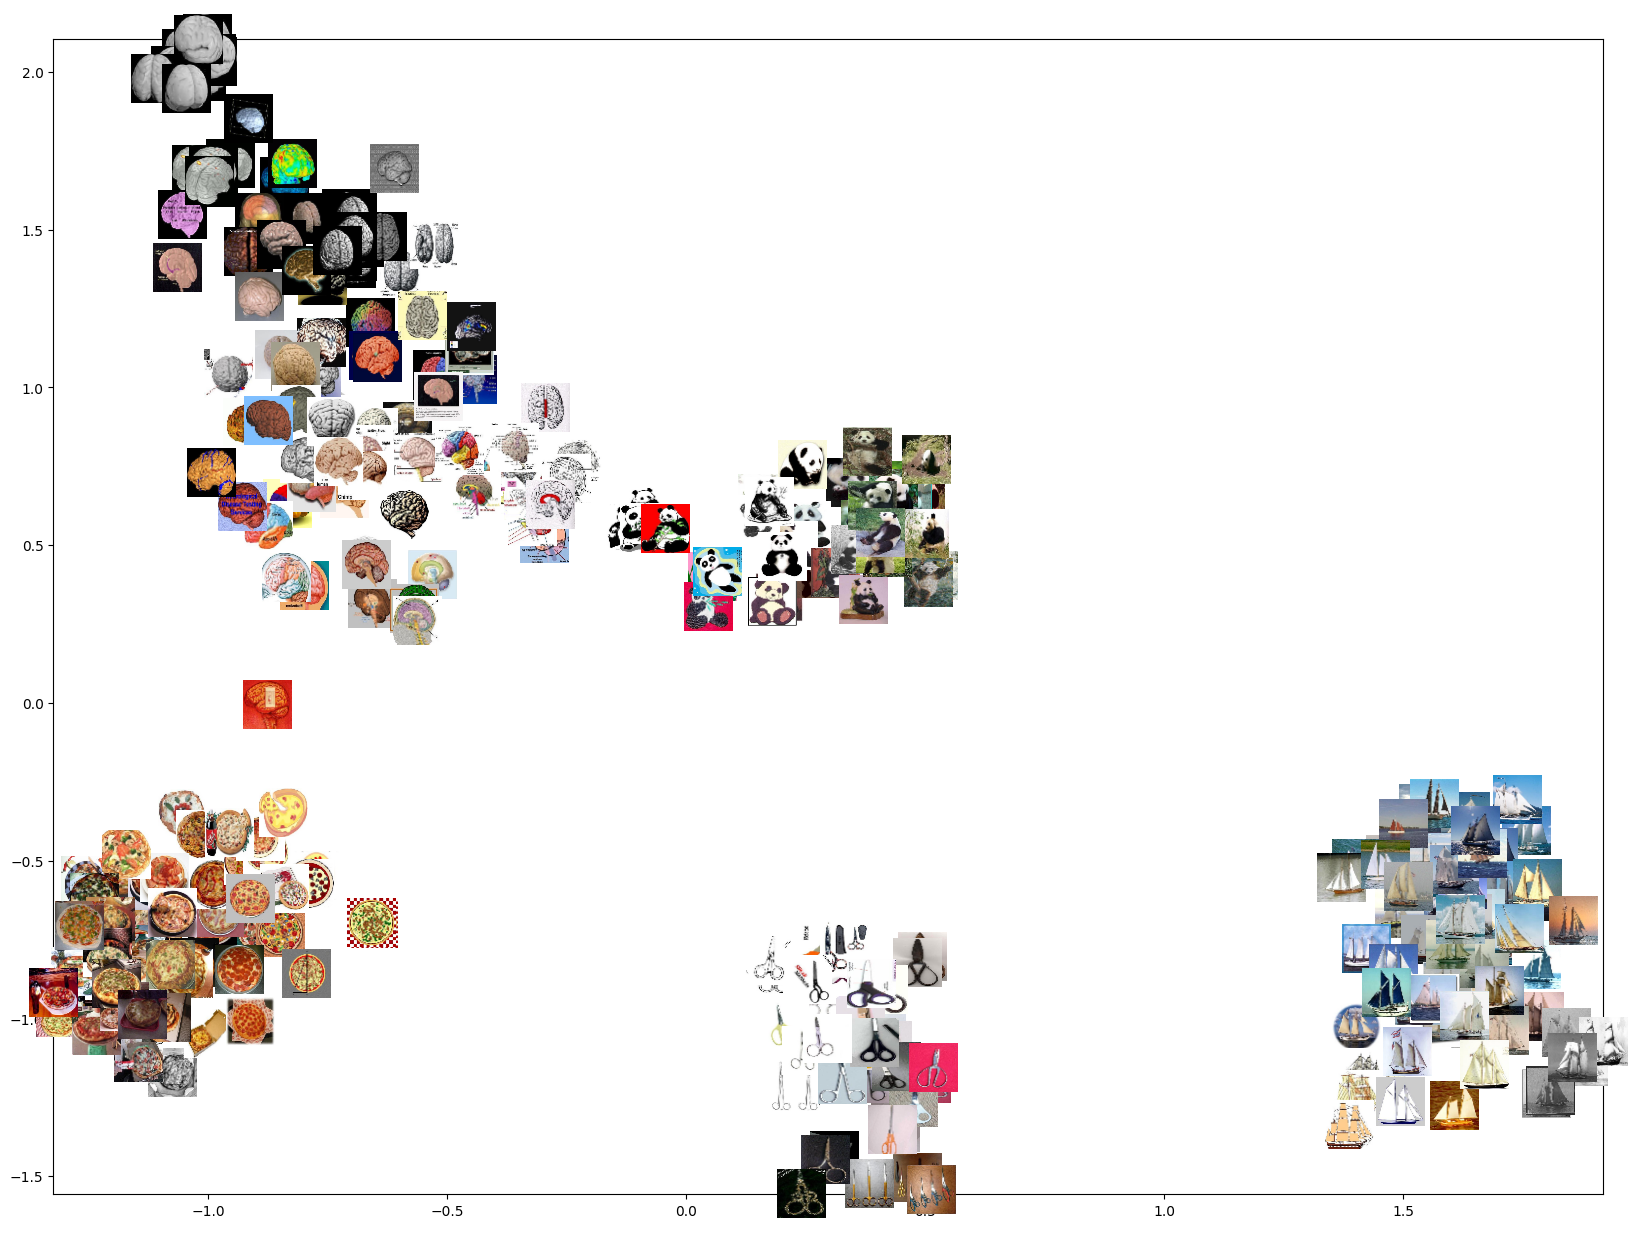

In [11]:
# рисуем
fig, ax = plt.subplots(figsize=(20,15))
artists = []

for xy, i in zip(tsne_result_scaled, images): # перебираем TSNE вектора (это двумерные координаты) и изображения
  x0, y0 = xy # разделяем горизонтальную и вертикальную координату
  img = OffsetImage(i, zoom=.7) # задаем графический объект с картинкой
  ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False) # вставляем эту картинку по координатам из вектора TSNE
  artists.append(ax.add_artist(ab)) # добавляем на график
ax.update_datalim(tsne_result_scaled) # пределы отображения
ax.autoscale(enable=True, axis='both', tight=True) # автомасштаб
plt.show() # отображаем

И действительно, видим, что похожие изображения собрались в группы. Установили, что у "похожих" изображений "похожие" вектора.

Векторное представление это очень мощный инструмент обработки изображений, теперь мы можем работать с векторами вместо самих изображений. Найти похожие изображения? Нет проблем, сравните их вектора по косинусному расстоянию.

In [12]:
# путь к первому изображению
image_path1='101_ObjectCategories/Leopards/image_0001.jpg'
# его вектор, должен быть размером 1на2048
vector1 = np.reshape(img2vec.get_vec(image_path1),(1,-1))

# путь ко второму изображению
image_path2='101_ObjectCategories/Motorbikes/image_0001.jpg'
# его вектор, должен быть размером 1на2048
vector2 = np.reshape(img2vec.get_vec(image_path2),(1,-1))

# их похожесть, чем больше тем похожей
similarity_matrix = cosine_similarity(vector1, vector2)

print('для разных ',similarity_matrix[0][0])

# путь к третьему изображению
image_path3='101_ObjectCategories/Motorbikes/image_0005.jpg'
# его вектор, должен быть размером 1на2048
vector3 = np.reshape(img2vec.get_vec(image_path3),(1,-1))

# их похожесть, чем больше тем похожей
similarity_matrix = cosine_similarity(vector3, vector2)

print('для похожих ',similarity_matrix[0][0])

1/1 [==============================] - 0s 26ms/step
для разных  0.25689083
1/1 [==============================] - 0s 21ms/step
для похожих  0.89999753


# Ссылки
Использованы и адаптированы материалы:


https://github.com/jaredwinick/img2vec-keras

